# Multi Layer Perceptron

## Importing the libraries

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tqdm
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Check GPU

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Loading MNIST dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))])

trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 189575082.05it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 43247302.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 62827189.78it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6000166.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Exploring the dataset

### Dataset shape and size

In [4]:
train_shape = trainset.data.shape
print(f"Train data size: {train_shape[0]}")
print(f"Train data shape: {train_shape[1:]}")

Train data size: 60000
Train data shape: torch.Size([28, 28])


In [5]:
test_shape = testset.data.shape
print(f"Test data size: {test_shape[0]}")
print(f"Test data shape: {test_shape[1:]}")

Test data size: 10000
Test data shape: torch.Size([28, 28])


### Sample image from each class

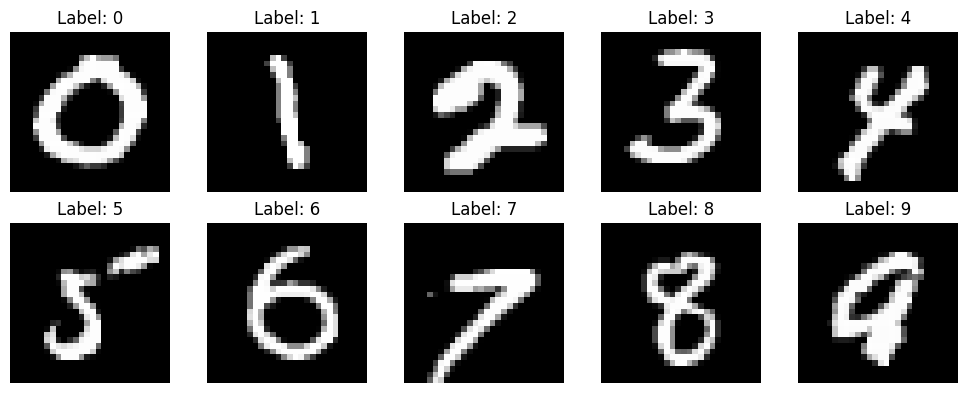

In [6]:
samples = []
labels = []

label_indices = [[] for _ in range(len(trainset.classes))]
for idx, (sample, label) in enumerate(trainset):
    label_indices[label].append(idx)

for label in range(len(trainset.classes)):
    random_idx = random.choice(label_indices[label])
    samples.append(trainset[random_idx][0])
    labels.append(trainset[random_idx][1])
    
rows = 2
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
for i in range(rows):
    for j in range(cols):
        axs[i, j].imshow(samples[i*cols+j][0], cmap='gray')
        axs[i, j].set_title(f"Label: {labels[i*cols+j]}")
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

### Histogram of sample count per class in training set

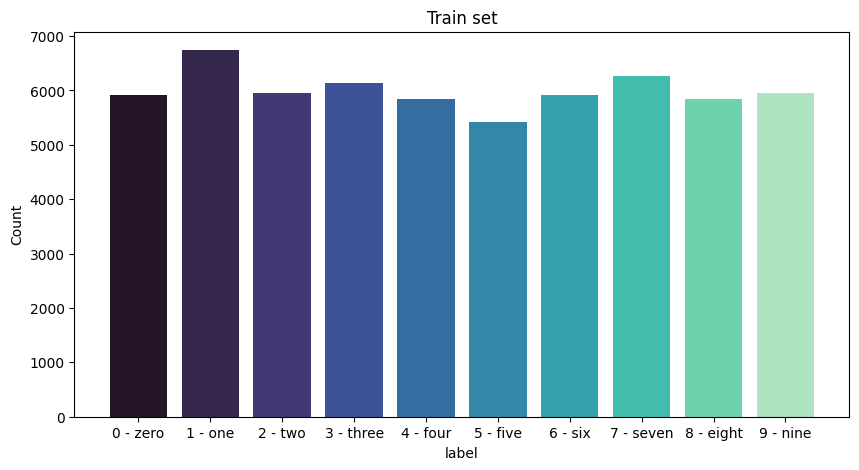

In [7]:
plt.figure(figsize=(10, 5))
plt.bar(trainset.classes, [len(label_indices[i]) for i in range(len(trainset.classes))], color=sns.color_palette("mako", len(trainset.classes)))
plt.title("Train set")
plt.xlabel("label")
plt.ylabel("Count")
plt.show()

### Normalizing the dataset using min-max scaling

This part has been done using transform function of torchvision.transforms while loading the dataset.

In [8]:
# trainset.data = trainset.data.type(torch.float32)
# trainset.data = (trainset.data - trainset.data.min()) / (trainset.data.max() - trainset.data.min())

In [9]:
# testset.data = testset.data.type(torch.float32)
# testset.data = (testset.data - testset.data.min()) / (testset.data.max() - testset.data.min())

## Teacher Network

### Defining the network

In [10]:
class Classifier(nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_size, hidden1_size)
        self.act_fn1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden1_size, hidden2_size)
        self.act_fn2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.act_fn1(x)
        x = self.linear2(x)
        x = self.act_fn2(x)
        x = self.linear3(x)
        return x


In [11]:
teacher_model = Classifier(28*28, 1024, 512, 10)
teacher_model.to(device)

Classifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (act_fn1): ReLU()
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (act_fn2): ReLU()
  (linear3): Linear(in_features=512, out_features=10, bias=True)
)

### Loss function

In [12]:
loss_module = nn.CrossEntropyLoss()

### Optimizer

In [13]:
learning_rate = 0.01
optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate)

### Data Loader

In [14]:
batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

### Training the model

In [15]:
epochs = 20

In [16]:
def train_model(model, data_loader, optimizer, loss_module, num_epochs):
    
    model.train()

    loss_vals = []
    num_preds = []
    cor_preds = []

    for epoch in tqdm.tqdm(range(num_epochs)):

        epoch_loss = []
        epoch_num_preds = 0
        epoch_cor_preds = 0

        for images, labels in data_loader:
            
            images = images.to(device)
            labels = labels.to(device)
            
            preds = model(images)
            preds = preds.squeeze(dim=1)

            loss = loss_module(preds, labels.long())

            optimizer.zero_grad()

            loss.backward()
            epoch_loss.append(loss.item())

            optimizer.step()

            epoch_num_preds += len(labels)
            epoch_cor_preds += (preds.argmax(dim=1) == labels).sum().item()

        loss_vals.append(np.mean(epoch_loss))
        num_preds.append(epoch_num_preds)
        cor_preds.append(epoch_cor_preds)

    return loss_vals, num_preds, cor_preds


In [17]:
def plot_training_summary(loss_vals, num_preds, cor_preds):

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_vals)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training loss")

    plt.subplot(1, 2, 2)
    plt.plot(np.linspace(1, epochs, epochs).astype(int), np.array(cor_preds) / np.array(num_preds))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training accuracy")

    plt.tight_layout()
    plt.show()
    

In [18]:
teacher_loss_vals_training, teacher_num_preds_training, teacher_cor_preds_training = train_model(teacher_model, trainloader, optimizer, loss_module, epochs)


100%|██████████| 20/20 [04:14<00:00, 12.71s/it]


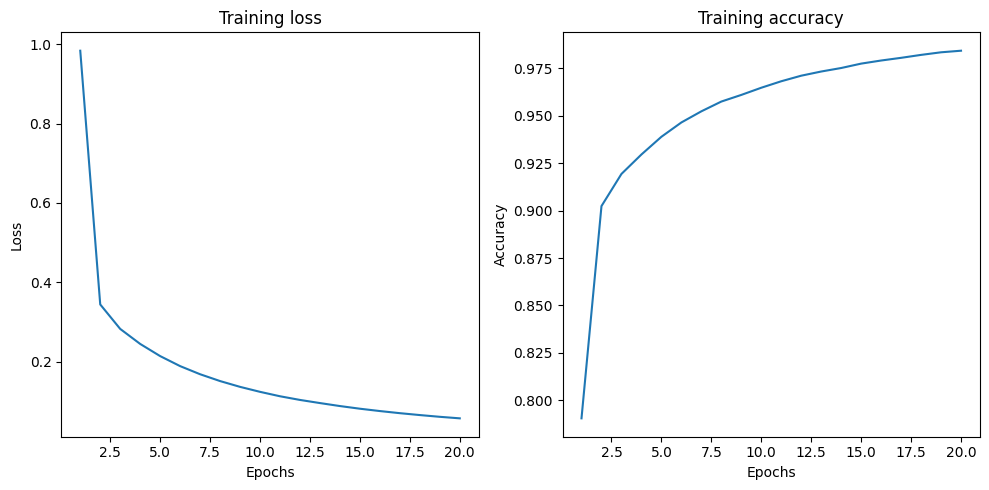

In [19]:
plot_training_summary(teacher_loss_vals_training, teacher_num_preds_training, teacher_cor_preds_training)

### Evaluating the model

In [20]:
def eval_model(model, data_loader):
    
    model.eval()
    
    num_preds = 0
    true_preds = 0

    # lables = []
    # preds = []

    with torch.no_grad():
        for images, labels in data_loader:

            images = images.to(device)
            labels = labels.to(device)

            pred_logits = model(images)
            pred_logits = pred_logits.squeeze(dim=1)

            pred_labels = torch.argmax(pred_logits, dim=1)

            # preds.append(pred_labels)
            # lables.append(labels)

            num_preds += pred_labels.size(0)
            true_preds += (pred_labels == labels).sum()
    
    return num_preds, true_preds

In [21]:
teacher_num_preds_eval, teacher_true_preds_eval = eval_model(teacher_model, testloader)

print(f"Accuracy: {(teacher_true_preds_eval/teacher_num_preds_eval)*100:.2f}%")
print(f"Number of correct predictions: {teacher_true_preds_eval}/{teacher_num_preds_eval}")
print(f"Number of misclassifications: {teacher_num_preds_eval - teacher_true_preds_eval}")

Accuracy: 97.67%
Number of correct predictions: 9767/10000
Number of misclassifications: 233


In [22]:
def plot_confusion_matrix(labels, preds, classes):
        
        fig, ax = plt.subplots(figsize=(10, 10))
        
        cm = confusion_matrix(labels, preds)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=classes, yticklabels=classes)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

# plot_confusion_matrix(labels.cpu(), preds.cpu(), trainset.classes)

## Student Network

### Defining the network

In [23]:
student_model = Classifier(28*28, 128, 64, 10)
student_model.to(device)

Classifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (act_fn1): ReLU()
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (act_fn2): ReLU()
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

### Loss function

In [24]:
loss_module = nn.CrossEntropyLoss()

### Optimizer

In [25]:
learning_rate = 0.01
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate)

### Data Loader

In [26]:
batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

### Training the model

In [27]:
epochs = 10
student1_loss_vals_training, student1_num_preds_training, student1_cor_preds_training = train_model(student_model, trainloader, optimizer, loss_module, epochs)

100%|██████████| 10/10 [02:04<00:00, 12.48s/it]


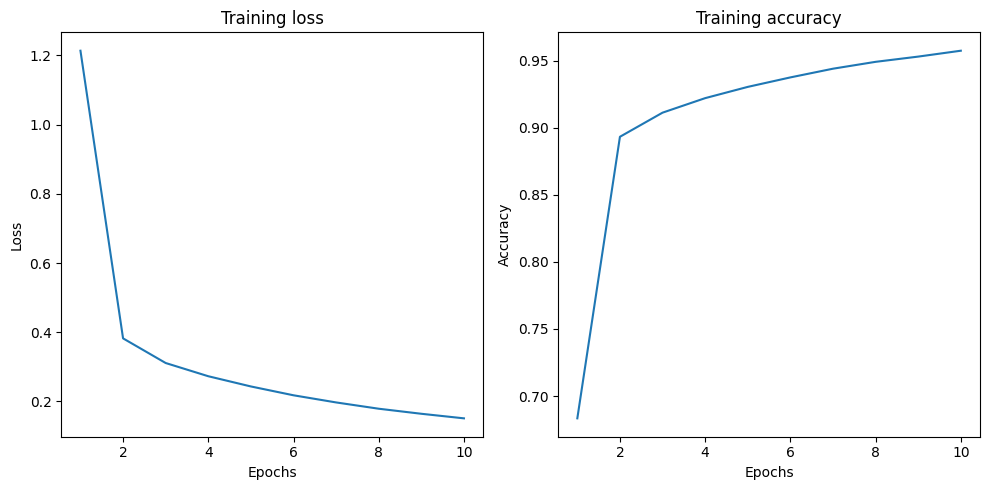

In [28]:
plot_training_summary(student1_loss_vals_training, student1_num_preds_training, student1_cor_preds_training)

### Evaluating the model

In [29]:
student1_num_preds_eval, student1_true_preds_eval = eval_model(student_model, testloader)

print(f"Accuracy: {(student1_true_preds_eval/student1_num_preds_eval)*100:.2f}%")
print(f"Number of correct predictions: {student1_true_preds_eval}/{student1_num_preds_eval}")
print(f"Number of misclassifications: {student1_num_preds_eval - student1_true_preds_eval}")

Accuracy: 95.63%
Number of correct predictions: 9563/10000
Number of misclassifications: 437


## Knowledge Distillation

### Generating logits from teacher network

In [30]:
images_list = []
labels_list = []
logits_list = []

with torch.no_grad():
    for images, labels in trainloader:

        images = images.to(device)
        labels = labels.to(device)
        
        logits = teacher_model(images)
        
        images_list.append(images)
        labels_list.append(labels)
        logits_list.append(logits)

images_list = torch.cat(images_list, dim=0)
labels_list = torch.cat(labels_list, dim=0)
logits_list = torch.cat(logits_list, dim=0)


### Defining the network

In [31]:
student_model_with_logits = Classifier(28*28, 128, 64, 10)
student_model_with_logits.to(device)

Classifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (act_fn1): ReLU()
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (act_fn2): ReLU()
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

### Loss function

In [32]:
loss_module = nn.MSELoss()

### Optimizer

In [33]:
learning_rate = 0.01
optimizer = optim.SGD(student_model_with_logits.parameters(), lr=learning_rate)

### Data Loader

In [34]:
class LogitsDataset(torch.utils.data.Dataset):
    
    def __init__(self, images, labels, logits):
        super().__init__()
        self.images = images
        self.labels = labels
        self.logits = logits

    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx], self.logits[idx]
    

In [35]:
batch_size = 32
trainset_with_logits = LogitsDataset(images_list, labels_list, logits_list)
trainloader_with_logits = DataLoader(trainset_with_logits, batch_size=batch_size, shuffle=True)


### Training the model

In [36]:
def train_student_model(model, data_loader, optimizer, loss_module, num_epochs):
    
    model.train()

    loss_vals = []
    num_preds = []
    cor_preds = []

    for epoch in tqdm.tqdm(range(num_epochs)):

        epoch_loss = []
        epoch_num_preds = 0
        epoch_cor_preds = 0

        for images, labels, logits in data_loader:
            
            images = images.to(device)
            labels = labels.to(device)
            logits = logits.to(device)
            
            preds = model(images)
            preds = preds.squeeze(dim=1)

            loss = loss_module(preds, logits)

            optimizer.zero_grad()

            loss.backward()
            epoch_loss.append(loss.item())

            optimizer.step()

            epoch_num_preds += len(preds)
            epoch_cor_preds += (preds.argmax(dim=1) == labels).sum().item()
            
        loss_vals.append(np.mean(epoch_loss))
        num_preds.append(epoch_num_preds)
        cor_preds.append(epoch_cor_preds)

    return loss_vals, num_preds, cor_preds


In [37]:
epochs = 10

student2_loss_vals_training, student2_num_preds_training, student2_cor_preds_training = train_student_model(student_model_with_logits, trainloader_with_logits, optimizer, loss_module, epochs)

100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


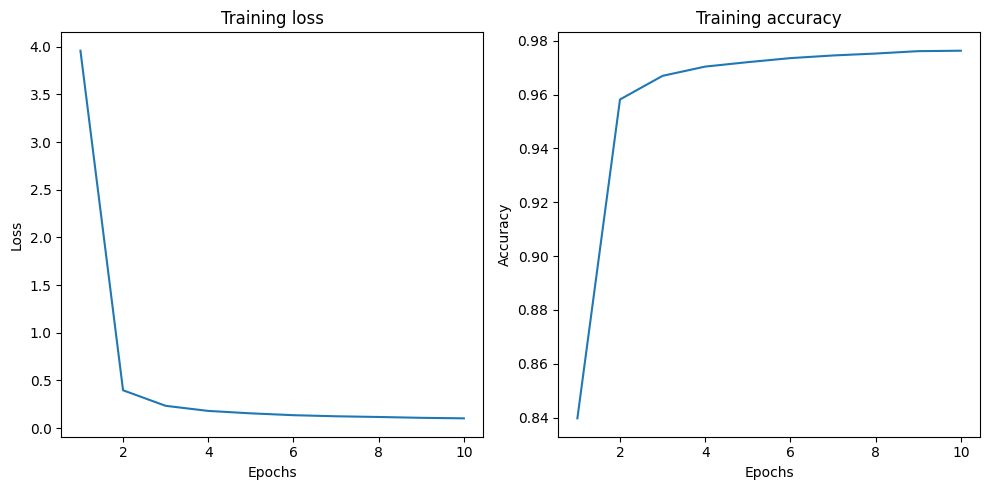

In [38]:
plot_training_summary(student2_loss_vals_training, student2_num_preds_training, student2_cor_preds_training)

### Evaluating the model

In [39]:
student2_num_preds_eval, student2_true_preds_eval = eval_model(student_model_with_logits, testloader)

print(f"Accuracy: {(student2_true_preds_eval/student2_num_preds_eval)*100:.2f}%")
print(f"Number of correct predictions: {student2_true_preds_eval}/{student2_num_preds_eval}")
print(f"Number of misclassifications: {student2_num_preds_eval - student2_true_preds_eval}")

Accuracy: 97.19%
Number of correct predictions: 9719/10000
Number of misclassifications: 281


## Comparing the performance of the models

### Misclassification count

In [40]:
print(f"First model misclassifications: {student1_num_preds_eval - student1_true_preds_eval}")
print(f"Second model misclassifications: {student2_num_preds_eval - student2_true_preds_eval}")
print(f"Accuracy improvement: {(student2_true_preds_eval/student1_true_preds_eval)*100 - (student1_true_preds_eval/teacher_true_preds_eval)*100:.2f}%")

First model misclassifications: 437
Second model misclassifications: 281
Accuracy improvement: 3.72%


### Accuracy plot during training

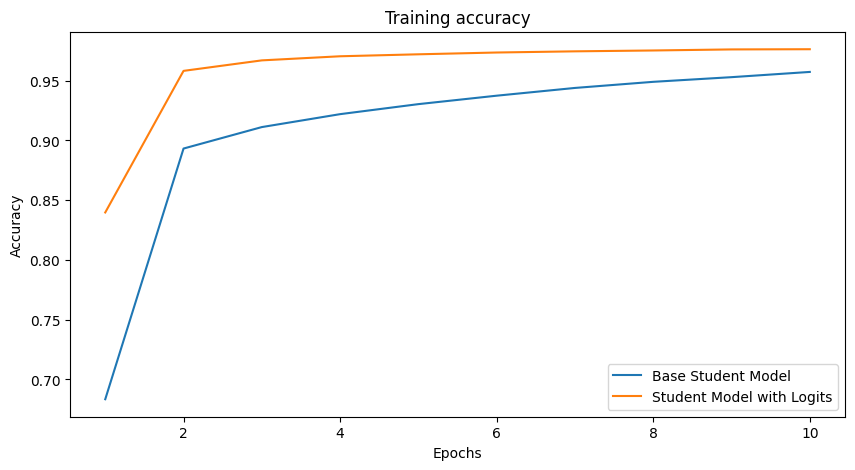

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(1, epochs, epochs).astype(int), np.array(student1_cor_preds_training) / np.array(student1_num_preds_training), label="Base Student Model")
plt.plot(np.linspace(1, epochs, epochs).astype(int), np.array(student2_cor_preds_training) / np.array(student2_num_preds_training), label="Student Model with Logits")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training accuracy")
plt.legend()
plt.show()
